# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#sns.set_theme('whitegrid')

# Define parameters

In [2]:
#target = 'bandgap'
#folder = 'MP-Fv-500-T'
folder = 'MChX-bandgap'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std':      f'{r_folder}/ref_dataset_std.pt',
    'r_std_parameters':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data': f'{r_folder}/uncertainty_data.json',
    'model':              f'{r_folder}/model.pt',
    'dataset_parameters': f'{r_folder}/dataset_parameters.json',
    't_dataset':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
# Note that you can as well load a non-standardized dataset and
# then use the cld.standardize_dataset_from_keys function
r_dataset_std = torch.load(files_names['r_dataset_std'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dataset_parameters'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Target dataset

In [5]:
# Load the standardized dataset, with corresponding labels and parameters
# We provide the cld.generate_dataset to generate the dataset
# from an existing database if this does not exist yet
if not os.path.exists(files_names['t_dataset']):
    # Generate data
    cld.generate_dataset(f'{t_folder}/MChX-bandgap',
                         targets=['bandgap'],
                         data_folder=t_folder)
t_dataset = torch.load(files_names['t_dataset'], weights_only=False)

# Extract the ground-truths, or input them manually
# This is only requested for testing the performance of the method, not for actual production
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [7]:
import importlib
importlib.reload(clm)

<module 'libraries.model' from '/home/claudio/cibran/Work/UPC/CLUE/libraries/model.py'>

# Plot target predictions

In [8]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, are_interpolated = clm.forward_predictions(r_dataset_std,
                                                                       t_dataset_std,
                                                                       model, r_std_parameters, r_uncertainty_data)

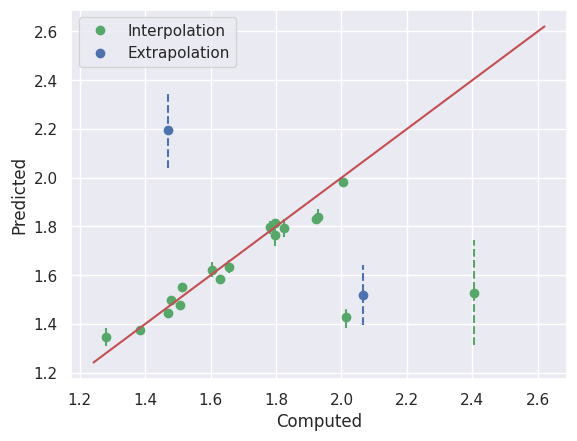

In [9]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = np.abs(uncertainties[are_interpolated])

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g--')

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = np.abs(uncertainties[~are_interpolated])

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b--')

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-target-prediction-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
random_integers = np.random.randint(0, len(ground_truths), size=10)

ground_truths_x    = ground_truths[random_integers]
predictions_x      = predictions[random_integers]
uncertainties_x    = uncertainties)[random_integers]
are_interpolated_x = are_interpolated[random_integers]

# Extract and plot interpolation data
xpred_interp = ground_truths_x[are_interpolated_x]
ypred_interp = predictions_x[are_interpolated_x]
yerr_interp  = uncertainties_x[are_interpolated_x]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths_x[~are_interpolated_x]
ypred_extra = predictions_x[~are_interpolated_x]
yerr_extra  = uncertainties_x[~are_interpolated_x]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths_x + uncertainties_x,
    ground_truths_x - uncertainties_x,
    predictions_x
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-target-prediction-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
print('Interpolated:')
for i, data in enumerate(t_dataset_std):
    if  are_interpolated[i]:
        print(data.label, ground_truths[i])

Interpolated:
MChX 1.0_0.25_0.25 1.3830000162124634
MChX 1.0_0.5_0.5 1.4700000286102295
MChX 0.75_0.25_0.5 1.50600004196167
MChX 1.0_0.0_0.5 1.2799999713897705
MChX 0.0_0.75_0.0 1.781999945640564
MChX 0.5_0.0_0.0 1.4789999723434448
MChX 0.25_1.0_0.0 2.005000114440918
MChX extrinsec-3 2.015000104904175
MChX 1.0_0.75_0.25 1.656000018119812
MChX 0.0_1.0_0.5 1.9210000038146973
MChX 0.25_0.75_0.0 1.7960000038146973
MChX 0.5_1.0_0.5 1.9279999732971191
MChX 0.5_0.75_0.25 1.8240000009536743
MChX 0.0_0.0_0.0 1.5119999647140503
MChX 0.25_0.0_0.5 1.6030000448226929
MChX extrinsec-1 2.4059998989105225
MChX extrinsec-2 1.628000020980835
MChX 0.0_0.75_0.5 1.7960000038146973


In [12]:
print('Extrapolated:')
for i, data in enumerate(t_dataset_std):
    if not are_interpolated[i]:
        print(data.label, ground_truths[i])

Extrapolated:
MChX extrinsec-4 2.066999912261963
MChX extrinsec-5 1.4700000286102295


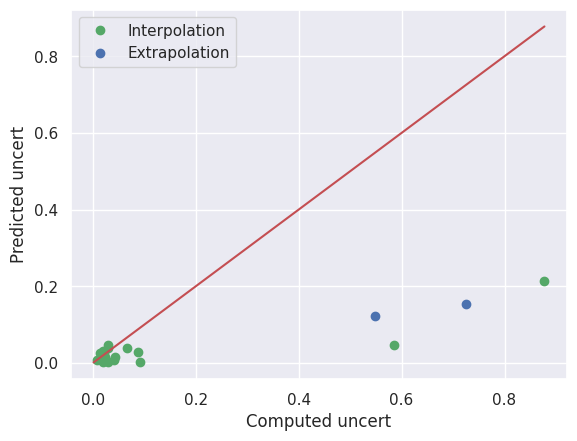

In [13]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-target-values-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot reference predictions

In [14]:
# Compute predictions with uncertainty estimation
predictions, uncertainties, are_interpolated = clm.forward_predictions(r_dataset_std,
                                                                       r_dataset_std,
                                                                       model, r_std_parameters, r_uncertainty_data)

In [15]:
ground_truths = np.array([data.y.item() for data in r_dataset_std])
ground_truths = ground_truths * r_std_parameters['target_std'] / r_std_parameters['scale'] + r_std_parameters['target_mean']

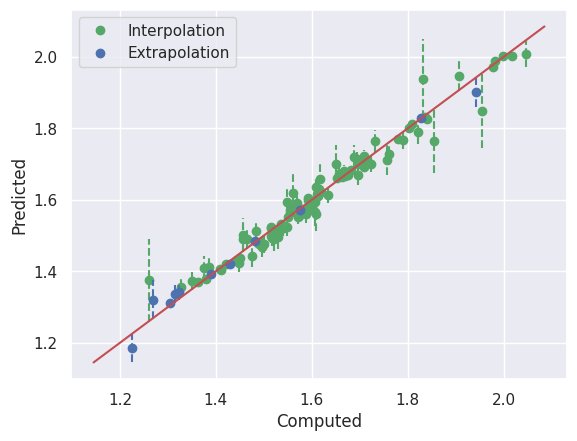

In [16]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp  = uncertainties[are_interpolated]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra  = uncertainties[~are_interpolated]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')  # Predictions
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y - err, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + uncertainties,
    ground_truths - uncertainties,
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-reference-prediction-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

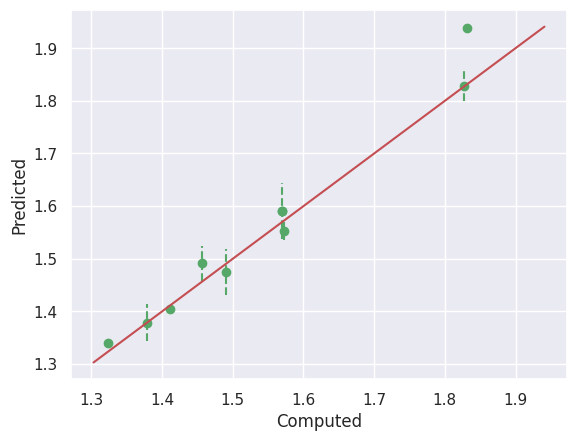

In [17]:
random_integers = np.random.randint(0, len(ground_truths), size=10)
random_integers

ground_truths_x = ground_truths[random_integers]
predictions_x = predictions[random_integers]
uncertainties_x = np.abs(uncertainties)[random_integers]
are_interpolated_x = are_interpolated[random_integers]

plt.plot(ground_truths_x, predictions_x, 'og')
for x, y, err in zip(ground_truths_x, predictions_x, yerr_interp):
    plt.plot([x, x], [y - err, y + err], 'g--')

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths_x + np.abs(uncertainties_x),
    ground_truths_x - np.abs(uncertainties_x),
    predictions_x
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.savefig(f'{t_folder}/UQ-reference-prediction-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

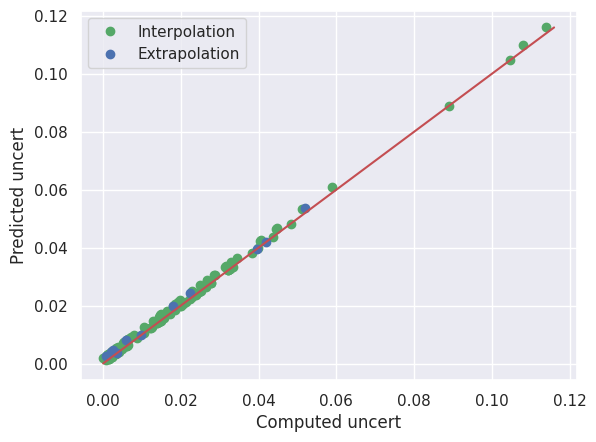

In [18]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-reference-values-comparison.png', dpi=300, bbox_inches='tight')
plt.show()